# NonMaximumSuppression

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches

画像読み込み

In [2]:
rscImg = cv2.imread("./data/lena.jpg", cv2.IMREAD_COLOR)
tmpImg = cv2.imread("./data/template.jpg", cv2.IMREAD_COLOR)
print(type(rscImg))
print(type(tmpImg))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


BGR(opencv) -> RGB(matplotlib)に変換

In [3]:
rgbRscImg = cv2.cvtColor(rscImg, cv2.COLOR_BGR2RGB)
rgbTmpImg = cv2.cvtColor(tmpImg, cv2.COLOR_BGR2RGB)

rgbRscImg and rgbTmpImg

(250, 250, 3)
(92, 70, 3)


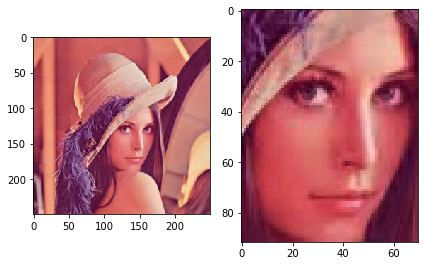

In [4]:
fig, ax = plt.subplots(1,2)
ax[0].imshow(rgbRscImg)
ax[1].imshow(rgbTmpImg)
plt.tight_layout()
print(rgbRscImg.shape)
print(rgbTmpImg.shape)

矩形を描画する関数

In [5]:
def draw_boxes(img, boxes, title):
    plt.figure(figsize=(8,8))
    ax = plt.gca()
    ax.axis('off')
    ax.set_title(title)
    ax.imshow(img)
    
    for box in boxes:
        x, y = box[:2]
        w, h = box[2:] - box[:2] + 1
        
        ax.add_patch(patches.Rectangle((x,y), w, h, linewidth=1, edgecolor='green', fill=None))
    plt.show()

テンプレートマッチング

In [6]:
# テンプレートマッチング
results = cv2.matchTemplate(rgbRscImg, rgbTmpImg, cv2.TM_CCOEFF_NORMED)

# 類似度が0.9以上の位置及びスコアを取得
positions = np.where(results >= 0.9)
scores = results[positions]

In [7]:
# 原画像に対してテンプレート画像をマッチングさせた時のBoundingBoxのスコア数
print(results.shape)
results

(159, 181)


array([[-0.18575221, -0.1982604 , -0.20645538, ..., -0.21169636,
        -0.2191335 , -0.22714584],
       [-0.19450459, -0.20564006, -0.21222532, ..., -0.20957376,
        -0.21747112, -0.22637632],
       [-0.20266525, -0.21207707, -0.2170864 , ..., -0.2088564 ,
        -0.21714798, -0.22648796],
       ...,
       [ 0.05529272,  0.02335071, -0.00795383, ...,  0.28347176,
         0.28603908,  0.28446662],
       [ 0.05498762,  0.02228506, -0.01019989, ...,  0.2799243 ,
         0.28319076,  0.2826746 ],
       [ 0.05510385,  0.02129557, -0.01269573, ...,  0.27668184,
         0.28152522,  0.28300583]], dtype=float32)

In [8]:
positions # (x, y)

(array([95, 96, 96, 97, 97, 97, 98, 98, 98, 99]),
 array([104, 103, 104, 102, 103, 104, 102, 103, 104, 102]))

In [10]:
scores

array([0.9014127 , 0.9584789 , 0.94031227, 0.94010913, 0.99577665,
       0.9410222 , 0.94085515, 0.9593301 , 0.9024323 , 0.9022612 ],
      dtype=float32)

テンプレートマッチングの結果をもとに矩形一覧を作成する

In [11]:
# 矩形に変換
boxes = []
h, w = rgbTmpImg.shape[:2]
for y, x in zip(*positions):
    boxes.append([x, y, x + w - 1, y + h - 1])
print("[x1, y1, x2, y2]:\n", boxes)
boxes = np.array(boxes)

[x1, y1, x2, y2]:
 [[104, 95, 173, 186], [103, 96, 172, 187], [104, 96, 173, 187], [102, 97, 171, 188], [103, 97, 172, 188], [104, 97, 173, 188], [102, 98, 171, 189], [103, 98, 172, 189], [104, 98, 173, 189], [102, 99, 171, 190]]


検出されたBoundingBoxの数

boxes.shape (10, 4)


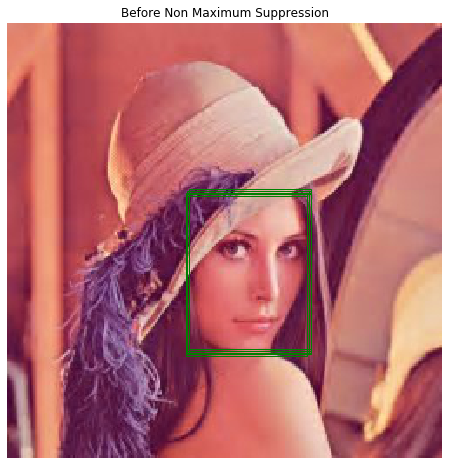

In [12]:
# 検出された矩形の数
print('boxes.shape', boxes.shape)

# 矩形一覧を描画
drawnImg = rgbRscImg.copy()
draw_boxes(drawnImg, boxes, "Before Non Maximum Suppression")

### Non-Maximum Suppressionの実装

In [13]:
def non_maximum_suppresion(boxes, scores, overlap_thresh):
    """Non Maximum Suppression を行う
    
    Args:
        boxes: (N, 4)のnumpy配列。矩形一覧。
        scores: 0.9以上のスコアnumpy配列。
        overlap_thresh: [0, 1]の実数。
        
    Returns:
        boxes: (M, 4)のnumpy配列。 Non-Maximum Suppressionにより残った矩形一覧。
    """
    
    if boxes.size == 0:
        return []
    
    # Int型->float型に変換
    boxes = boxes.astype('float')
    
    # (NumOfBoxes, 4) -> x1, y1, x2, y2 の4つの配列(NumOfBoxes, 1)に分割
    x1, y1, x2, y2 = np.squeeze(np.split(boxes, 4, axis=1)) # np.squeeze()はいらない次元をなくす
    
    # 矩形の面積を計算する
    area = (x2 - x1 + 1) * (y2 - y1 + 1)
    
    # スコアを降順にソートしたインデックス一覧
    indices = np.argsort(scores)
    
    # Non-Maximum Suppressionにより選択されたインデックス一覧
    selected = []
    
    # indicesがなくなるまでループ 
    while len(indices) > 0:
        
        # indicesの最後の要素が一番スコアが高い
        last = len(indices) - 1
        selected_index = indices[last]
        remaining_indices = indices[:last]
        selected.append(selected_index)
        
        # 選択した矩形と残りの矩形の共通部分(UoI)のx1, y1, x2, y2を計算する
        i_x1 = np.maximum(x1[selected_index], x1[remaining_indices])
        i_y1 = np.maximum(y1[selected_index], y1[remaining_indices])
        i_x2 = np.minimum(x2[selected_index], x2[remaining_indices])
        i_y2 = np.minimum(y2[selected_index], y2[remaining_indices])
        
        # 選択した矩形と残りの矩形の共通部分(UoI)の幅・高さを計算する
        i_w = np.maximum(0, i_x2 - i_x1 + 1)
        i_h = np.maximum(0, i_y2 - i_y1 + 1)
        
        # 選択した矩形と残りの矩形のOverlap Ratio を計算する
        overlap = (i_w * i_h) / area[remaining_indices]
        
        # 選択した矩形及びOverlap Ratio が閾値以上の矩形をindicesから削除
        indices = np.delete(indices, np.concatenate(([last], np.where(overlap > overlap_thresh)[0])))
        
        # 選択された矩形の一覧を返す
        return boxes[selected].astype("int")

In [14]:
print(boxes)
a = np.split(boxes, 4, axis=1)
print(a)
print(a.shape)

[[104  95 173 186]
 [103  96 172 187]
 [104  96 173 187]
 [102  97 171 188]
 [103  97 172 188]
 [104  97 173 188]
 [102  98 171 189]
 [103  98 172 189]
 [104  98 173 189]
 [102  99 171 190]]
[array([[104],
       [103],
       [104],
       [102],
       [103],
       [104],
       [102],
       [103],
       [104],
       [102]]), array([[95],
       [96],
       [96],
       [97],
       [97],
       [97],
       [98],
       [98],
       [98],
       [99]]), array([[173],
       [172],
       [173],
       [171],
       [172],
       [173],
       [171],
       [172],
       [173],
       [171]]), array([[186],
       [187],
       [187],
       [188],
       [188],
       [188],
       [189],
       [189],
       [189],
       [190]])]


AttributeError: 'list' object has no attribute 'shape'

In [15]:
a = [[1,2,3,4], [5,6,7,8]]
b = np.array(a)

In [16]:
b

array([[1, 2, 3, 4],
       [5, 6, 7, 8]])

In [17]:
np.split(b, 2, axis=0)

[array([[1, 2, 3, 4]]), array([[5, 6, 7, 8]])]

In [18]:
c = np.split(b, 4, axis=1)
c

[array([[1],
        [5]]),
 array([[2],
        [6]]),
 array([[3],
        [7]]),
 array([[4],
        [8]])]

In [19]:
np.squeeze(c)

array([[1, 5],
       [2, 6],
       [3, 7],
       [4, 8]])

In [20]:
x1, y1, x2, y2 = np.squeeze(c)

In [21]:
print(x1)
print(y1)
print(x2)
print(y2)

[1 5]
[2 6]
[3 7]
[4 8]


In [22]:
w = x2 - x1 + 1
w

array([3, 3])

In [23]:
h = y2 - y1 + 1
h

array([3, 3])

In [24]:
w * h

array([9, 9])

### Non-Maximum Suppressionを適用する　

boxes.shape (1, 4)


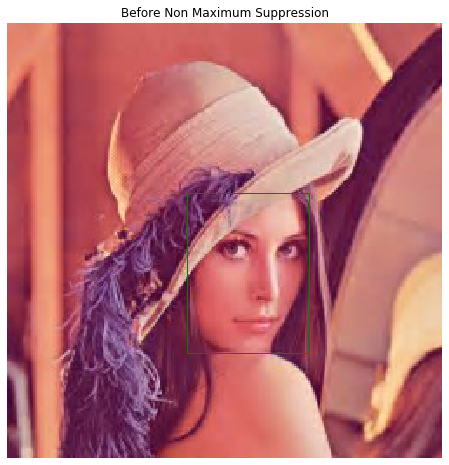

In [25]:
# Non Maximum Suppressionを行う
boxes = non_maximum_suppresion(boxes, scores, overlap_thresh=0.6)
print('boxes.shape', boxes.shape) # boxes.shape (1, 4)

# NMS 後に残った矩形一覧を描画する
draw_boxes(drawnImg, boxes, "Before Non Maximum Suppression")